In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Dados do problema
Re = 10.0           # Número de Reynolds [cite: 20]
N_reais = 11        # Volumes de controle reais [cite: 21]
N = N_reais + 2     # Total de volumes (incluindo 2 fictícios) [cite: 17]
dx = 1.0 / N_reais  # Tamanho do volume [cite: 41]
beta = 1.0          # 1.0 para CDS (correção adiada), 0.0 para UDS puro [cite: 46]

# Posições dos centros dos volumes (xp) [cite: 56]
x = np.zeros(N)
x[0] = 0.0  # Contorno esquerdo
for i in range(1, N-1):
    x[i] = (i - 0.5) * dx
x[-1] = 1.0 # Contorno direito

# Solução analítica para comparação e estimativa inicial [cite: 18]
def sol_analitica(x_val):
    if Re == 0: return x_val
    return (np.exp(Re * x_val) - 1.0) / (np.exp(Re) - 1.0)

uanl = np.array([sol_analitica(xi) for xi in x])
u = uanl.copy()  # Estimativa inicial [cite: 18]

In [4]:
def tdma(a_w, a_p, a_e, b_p):
    n = len(a_p)
    P = np.zeros(n)
    Q = np.zeros(n)
    T = np.zeros(n)
    
    # Eliminação progressiva [cite: 61]
    P[0] = a_e[0] / a_p[0]
    Q[0] = b_p[0] / a_p[0]
    
    for i in range(1, n):
        m = a_p[i] - a_w[i] * P[i-1]
        P[i] = a_e[i] / m
        Q[i] = (b_p[i] + a_w[i] * Q[i-1]) / m
        
    # Substituição regressiva [cite: 61]
    T[-1] = Q[-1]
    for i in range(n-2, -1, -1):
        T[i] = P[i] * T[i+1] + Q[i]
        
    return T

In [5]:
# Termo fonte S da equação [cite: 55]
def source_term(xi):
    den = (np.exp(Re) - 1.0)**2
    term = (Re**2) * np.exp(xi * Re) * (2.0 * np.exp(xi * Re) - np.exp(Re) - 1.0)
    return term / den

# Listas para convergência
iteracoes = []
u_meio_hist = []
erro_maq = 1e-16
max_iter = 1000

for it in range(max_iter):
    u_old = u.copy()
    aw = np.zeros(N)
    ae = np.zeros(N)
    ap = np.zeros(N)
    bp = np.zeros(N)
    
    # Volumes Internos [cite: 55]
    for i in range(1, N-1):
        # Difusão (CDS) + Advecção (UDS linearizado)
        aw[i] = (1.0 / dx) + Re * u_old[i-1] 
        ae[i] = (1.0 / dx)
        ap[i] = aw[i] + ae[i]
        
        # Termo fonte original + Correção Adiada (CDS - UDS)
        S = source_term(x[i])
        # A correção adiada entra em bp usando valores da iteração anterior
        correcao = 0.5 * beta * Re * (u_old[i]**2 - u_old[i-1]**2 - u_old[i+1]**2 + u_old[i]**2)
        bp[i] = S * dx + correcao 

    # Condições de Contorno (Volumes Fictícios) [cite: 53, 54]
    # u(0) = 0 -> (u[0] + u[1])/2 = 0 -> u[0] = -u[1]
    ap[0], ae[0], aw[0], bp[0] = 1.0, -1.0, 0.0, 0.0
    # u(1) = 1 -> (u[N-1] + u[N-2])/2 = 1 -> u[N-1] = 2 - u[N-2]
    ap[-1], ae[-1], aw[-1], bp[-1] = 1.0, 1.0, 0.0, 2.0

    # Resolve o sistema
    u = tdma(aw, ap, ae, bp)
    
    # Histórico para o gráfico
    iteracoes.append(it)
    u_meio_hist.append(u[N//2])
    
    # Critério de parada (Erro de arredondamento de máquina) [cite: 23]
    if np.max(np.abs(u - u_old)) < erro_maq:
        print(f"Convergência atingida em {it} iterações.")
        break

Convergência atingida em 40 iterações.


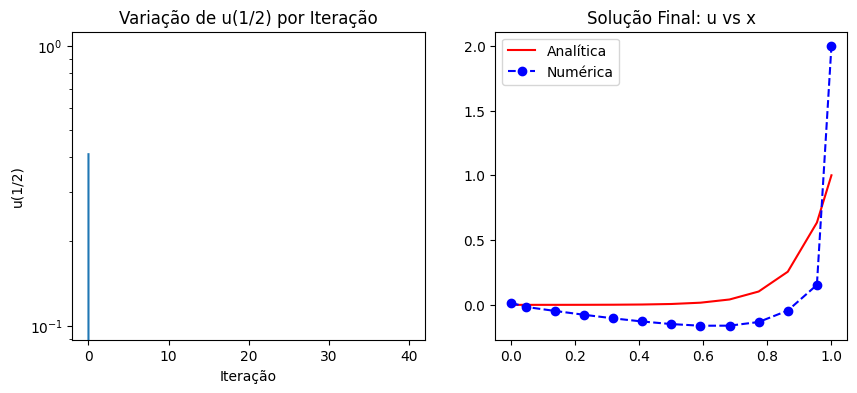

Nó    | xp       | u_num           | u_anl           | Erro           
----------------------------------------------------------------------
0     | 0.0000   | 1.5781122376e-02 | 0.0000000000e+00 | -1.5781122376e-02
1     | 0.0455   | -1.5781122376e-02 | 2.6126898235e-05 | 1.5807249274e-02
2     | 0.1364   | -4.6852467003e-02 | 1.3213736753e-04 | 4.6984604370e-02
3     | 0.2273   | -7.6550149453e-02 | 3.9526225196e-04 | 7.6945411705e-02
4     | 0.3182   | -1.0402929099e-01 | 1.0483553405e-03 | 1.0507764634e-01
5     | 0.4091   | -1.2837749414e-01 | 2.6693748926e-03 | 1.3104686903e-01
6     | 0.5000   | -1.4826301071e-01 | 6.6928509243e-03 | 1.5495586163e-01
7     | 0.5909   | -1.6103796071e-01 | 1.6679380301e-02 | 1.7771734102e-01
8     | 0.6818   | -1.6059134101e-01 | 4.1466596185e-02 | 2.0205793719e-01
9     | 0.7727   | -1.3243308148e-01 | 1.0299007927e-01 | 2.3542316075e-01
10    | 0.8636   | -4.4109493187e-02 | 2.5569536854e-01 | 2.9980486172e-01
11    | 0.9545   | 1.5380732066e-

In [6]:
# 1) Gráfico de convergência [cite: 24]
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.semilogy(iteracoes, u_meio_hist)
plt.title("Variação de u(1/2) por Iteração")
plt.xlabel("Iteração")
plt.ylabel("u(1/2)")

# 4) Gráfico u vs x [cite: 28]
plt.subplot(1, 2, 2)
plt.plot(x, uanl, 'r-', label='Analítica')
plt.plot(x, u, 'bo--', label='Numérica')
plt.legend()
plt.title("Solução Final: u vs x")
plt.show()

# 2 e 3) Tabelas de Coeficientes e Erros [cite: 25, 27]
print(f"{'Nó':<5} | {'xp':<8} | {'u_num':<15} | {'u_anl':<15} | {'Erro':<15}")
print("-" * 70)
for i in range(N):
    erro = uanl[i] - u[i]
    print(f"{i:<5} | {x[i]:<8.4f} | {u[i]:<15.10e} | {uanl[i]:<15.10e} | {erro:<15.10e}")

# 5) Velocidade Média (Regra do Retângulo) 
u_media_num = np.sum(u[1:N-1]) / N_reais
u_media_anl = (np.exp(Re) - Re - 1) / (Re * (np.exp(Re) - 1)) # Integral de u(x) de 0 a 1
print(f"\nVelocidade Média Numérica: {u_media_num:.10f}")
print(f"Velocidade Média Analítica: {u_media_anl:.10f}")
print(f"Erro da Média: {u_media_anl - u_media_num:.10e}")

# 6) Média da norma do erro [cite: 30]
l1_norm = np.mean(np.abs(uanl - u))
print(f"Média da norma L1 do erro: {l1_norm:.10e}")